In [48]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp # for reference

import autograd.numpy as np
from neuralsolver import NNSolver
from sklearn.metrics import mean_squared_error
from math import sqrt
import time

# figure settings
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams['legend.fontsize'] = 13

plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 15

# Problem Definition

In [37]:
def f(t, y):
    # dx/dt = cos(t) + x^2 + y -(1 + t^2 + sin^2(t))
    # dt/dt = 2t - (1 + t^2)sin(t)+xy
    x = y[0]
    y = y[1]
    return [np.cos(t) + x**2 + y - (1 + t**2 + (np.sin(t))**2), 2*t - (1 + t**2)*np.sin(t) + x*y]

t = np.linspace(0, 3, 20).reshape(-1, 1) #training points
y0_list = [0, 1] 

In [38]:
t_ = np.linspace(0, 3, 20)
sol1 = [np.sin(tt) for tt in t_]
sol2 = [1 + (tt**2) for tt in t_]
solActual = [sol1, sol2]

# Reference solution

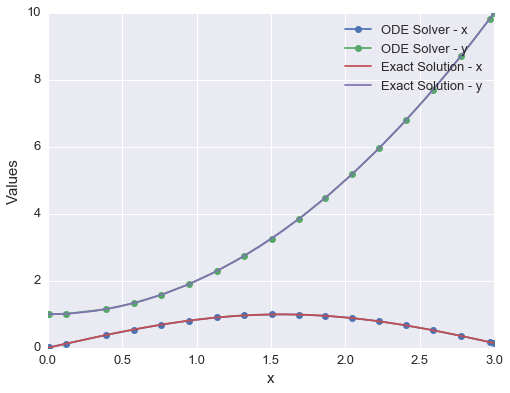

In [39]:
# reference solution using scipy package
sol = solve_ivp(f, [t.min(), t.max()], y0_list, method='Radau', rtol=1e-5)
plt.plot(sol.t, sol.y[0], marker='o', label='ODE Solver - x')
plt.plot(sol.t, sol.y[1], marker='o', label='ODE Solver - y')
plt.plot(t_, sol1, label = 'Exact Solution - x')
plt.plot(t_, sol2, label = 'Exact Solution - y')
plt.xlabel('x')
plt.ylabel('Values')
plt.legend()

# Neural Net Training

In [40]:
nn = NNSolver(f, t, y0_list, n_hidden=50)
nn

Neural ODE Solver 
Number of equations:       2 
Initial condition y0:      [0, 1] 
Numnber of hidden units:   50 
Number of training points: 20 

In [41]:
nn.reset_weights()
%time nn.train(maxiter=1000, iprint=100)

iteration: 0 loss:  52.271404308
iteration: 100 loss:  0.000114624786311
iteration: 200 loss:  1.36400363324e-06
iteration: 300 loss:  6.53080461044e-07
iteration: 400 loss:  3.00040056725e-07
iteration: 500 loss:  1.83182193865e-07
iteration: 600 loss:  8.44491319587e-08
iteration: 700 loss:  1.1985297071e-08
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 718
         Function evaluations: 816
         Gradient evaluations: 816
CPU times: user 15.9 s, sys: 236 ms, total: 16.2 s
Wall time: 12.4 s


# Verifying training set

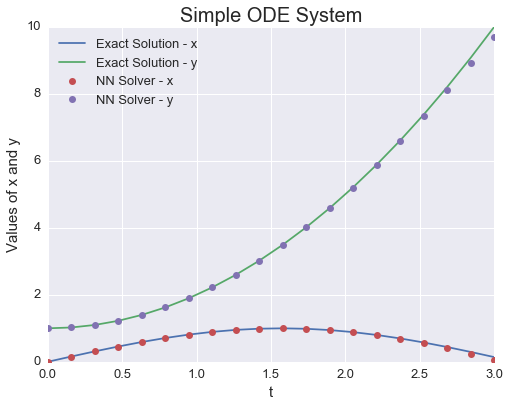

In [42]:
y_pred_list, dydt_pred_list = nn.predict()

plt.figure(figsize=(8, 6))
# exact soln
plt.plot(t_, sol1, label = 'Exact Solution - x')
plt.plot(t_, sol2, label = 'Exact Solution - y')

# nn soln
plt.plot(t, y_pred_list[0], 'o', label='NN Solver - x')
plt.plot(t, y_pred_list[1], 'o', label='NN Solver - y')

plt.legend(loc = 'best')
plt.ylabel('Values of x and y')
plt.xlabel('t')
plt.title("Simple ODE System");

In [43]:
np.mean([sqrt(mean_squared_error(solActual[i], y_pred_list[i])) for i in range(2)])

0.0524140323140935

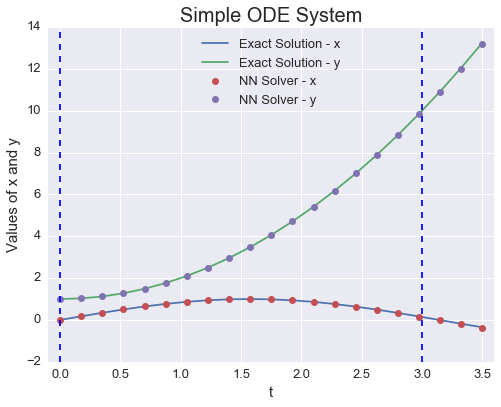

In [30]:
# not included
t_test = np.linspace(0, 3.5, 21).reshape(-1,1)
y_pred_list, dydt_pred_list = nn.predict(t = t_test)

t_ = np.linspace(0, 3.5, 21)
sol1_test = [np.sin(tt) for tt in t_]
sol2_test = [1 + (tt**2) for tt in t_]

plt.plot(t_, sol1_test, label = 'Exact Solution - x')
plt.plot(t_, sol2_test, label = 'Exact Solution - y')

plt.plot(t_test, y_pred_list[0], 'o', label='NN Solver - x')
plt.plot(t_test, y_pred_list[1], 'o', label='NN Solver - y')
plt.axvline(x = 0, linestyle = '--')
plt.axvline(x = 3 , linestyle = '--')
plt.xlim((-0.1, 3.6))
plt.legend(loc = 'best')
plt.title('Simple ODE System')
plt.ylabel('Values of x and y')
plt.xlabel('t')

# Performance over 100 Fittings

In [33]:
res_arr = []
for _ in range(100):
    nn = NNSolver(f, t, y0_list, n_hidden=20)
    nn.reset_weights()
    nn.train(maxiter=500)
    y_pred_list, dydt_pred_list = nn.predict()
    res_arr.append(np.mean([sqrt(mean_squared_error(solActual[i], y_pred_list[i])) for i in range(2)]))

iteration: 0 loss:  64.3916359453
iteration: 200 loss:  3.7522358992e-06
iteration: 400 loss:  4.80590244823e-08
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 477
         Function evaluations: 536
         Gradient evaluations: 536
iteration: 0 loss:  35.9483825332
iteration: 200 loss:  1.76708902594e-06
iteration: 400 loss:  3.10772157067e-07
         Current function value: 0.000000
         Iterations: 500
         Function evaluations: 558
         Gradient evaluations: 558
iteration: 0 loss:  371.20871902
iteration: 200 loss:  0.000211153184094
iteration: 400 loss:  2.36191999291e-06
         Current function value: 0.000000
         Iterations: 500
         Function evaluations: 560
         Gradient evaluations: 560
iteration: 0 loss:  8030.39055182
iteration: 200 loss:  3.45487612516e-06
iteration: 400 loss:  2.98150977527e-07
         Current function value: 0.000000
         Iterations: 500
         Function evaluations:

(array([ 48.,   7.,   7.,   0.,   0.,   0.,   0.,   0.,   0.,  38.]), array([  6.64004018e-04,   3.78358840e-01,   7.56053676e-01,
         1.13374851e+00,   1.51144335e+00,   1.88913818e+00,
         2.26683302e+00,   2.64452786e+00,   3.02222269e+00,
         3.39991753e+00,   3.77761237e+00]), <a list of 10 Patch objects>)


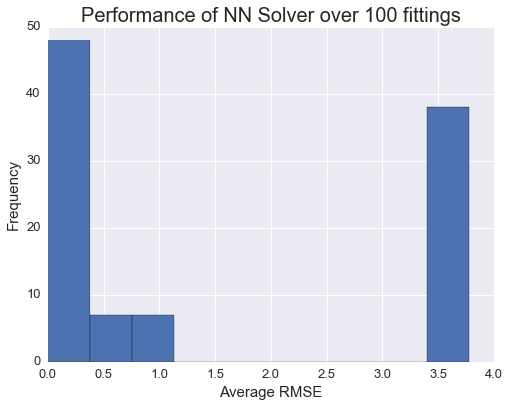

In [34]:
plt.figure(figsize= (8, 6))
figur = plt.hist(res_arr, bins=10)
plt.title('Performance of NN Solver over 100 fittings')
plt.xlabel('Average RMSE')
plt.ylabel('Frequency')
print (figur)

## Compare across different optimization techniques

In [49]:
def plot_loss_compare(model, maxiter = 1000, iprint = 200):
    model.reset_weights()
    save_init_paras_list = model.params_list
    save_init_flattened_params = model.flattened_params
    
    
    methods = ['CG','BFGS','L-BFGS-B']
    
    plt.figure(figsize=(8,6))
    for method in methods:
        
        model.params_list = save_init_paras_list
        model.flattened_params = save_init_flattened_params
        
        start_time = time.time()
        model.train(method = method, maxiter=maxiter, iprint=iprint)
        duration = time.time() - start_time
        
        plt.semilogy(range(len(model.loss)), model.loss, label = method + ' (time = {}s'.format(round(duration,2)) + ')')
        
    plt.legend()
    plt.title("Log Loss Comparision", fontsize = 20 )
    plt.xlabel("Iteration")
    plt.ylabel("Log Loss")
    plt.show()

iteration: 0 loss:  684.125650601
iteration: 200 loss:  0.0106458914493
iteration: 400 loss:  0.00512126417896
iteration: 600 loss:  0.00295376991575
iteration: 800 loss:  0.00142421986384
         Current function value: 0.001026
         Iterations: 1000
         Function evaluations: 2166
         Gradient evaluations: 2166
iteration: 0 loss:  684.125650601
iteration: 200 loss:  4.23233499533e-06
iteration: 400 loss:  4.64926409048e-07
iteration: 600 loss:  3.81781179317e-08
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 648
         Function evaluations: 734
         Gradient evaluations: 734
iteration: 0 loss:  625.407436379
iteration: 200 loss:  0.0839181824359
iteration: 400 loss:  0.00938149557062
iteration: 600 loss:  0.00169326486729
iteration: 800 loss:  0.00101871794301
iteration: 1000 loss:  0.00037587816812


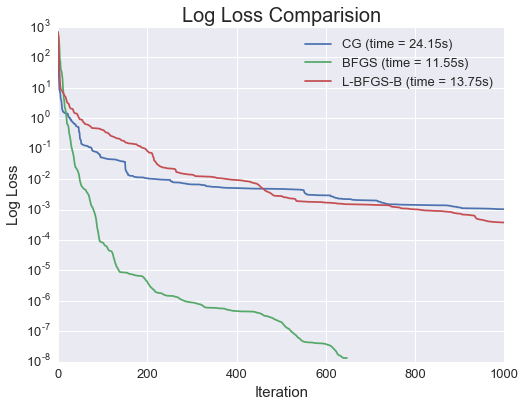

In [50]:
plot_loss_compare(nn)